# PHÂN TÍCH CHẤT LƯỢNG KHÔNG KHÍ

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

## Phát biểu bài toán

## Giới thiệu về dữ liệu

## Các câu hỏi phân tích

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [2]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {      
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read_excel("../../data/part2/air+quality/AirQualityUCI.xlsx", sheet = 1)
str(raw_data)

tibble [9,357 × 15] (S3: tbl_df/tbl/data.frame)
 $ Date         : POSIXct[1:9357], format: "2004-03-10" "2004-03-10" ...
 $ Time         : POSIXct[1:9357], format: "1899-12-31 18:00:00" "1899-12-31 19:00:00" ...
 $ CO(GT)       : num [1:9357] 2.6 2 2.2 2.2 1.6 1.2 1.2 1 0.9 0.6 ...
 $ PT08.S1(CO)  : num [1:9357] 1360 1292 1402 1376 1272 ...
 $ NMHC(GT)     : num [1:9357] 150 112 88 80 51 38 31 31 24 19 ...
 $ C6H6(GT)     : num [1:9357] 11.88 9.4 9 9.23 6.52 ...
 $ PT08.S2(NMHC): num [1:9357] 1046 955 939 948 836 ...
 $ NOx(GT)      : num [1:9357] 166 103 131 172 131 89 62 62 45 -200 ...
 $ PT08.S3(NOx) : num [1:9357] 1056 1174 1140 1092 1205 ...
 $ NO2(GT)      : num [1:9357] 113 92 114 122 116 96 77 76 60 -200 ...
 $ PT08.S4(NO2) : num [1:9357] 1692 1559 1554 1584 1490 ...
 $ PT08.S5(O3)  : num [1:9357] 1268 972 1074 1203 1110 ...
 $ T            : num [1:9357] 13.6 13.3 11.9 11 11.2 ...
 $ RH           : num [1:9357] 48.9 47.7 54 60 59.6 ...
 $ AH           : num [1:9357] 0.758 0.72

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 231 dòng và 14 cột
dim(raw_data)

[1] 9357   15

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [5]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


### Mỗi cột mang ý nghĩa gì?

In [6]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

tibble [9,357 × 15] (S3: tbl_df/tbl/data.frame)
 $ Date         : POSIXct[1:9357], format: "2004-03-10" "2004-03-10" ...
 $ Time         : POSIXct[1:9357], format: "1899-12-31 18:00:00" "1899-12-31 19:00:00" ...
 $ CO(GT)       : num [1:9357] 2.6 2 2.2 2.2 1.6 1.2 1.2 1 0.9 0.6 ...
 $ PT08.S1(CO)  : num [1:9357] 1360 1292 1402 1376 1272 ...
 $ NMHC(GT)     : num [1:9357] 150 112 88 80 51 38 31 31 24 19 ...
 $ C6H6(GT)     : num [1:9357] 11.88 9.4 9 9.23 6.52 ...
 $ PT08.S2(NMHC): num [1:9357] 1046 955 939 948 836 ...
 $ NOx(GT)      : num [1:9357] 166 103 131 172 131 89 62 62 45 -200 ...
 $ PT08.S3(NOx) : num [1:9357] 1056 1174 1140 1092 1205 ...
 $ NO2(GT)      : num [1:9357] 113 92 114 122 116 96 77 76 60 -200 ...
 $ PT08.S4(NO2) : num [1:9357] 1692 1559 1554 1584 1490 ...
 $ PT08.S5(O3)  : num [1:9357] 1268 972 1074 1203 1110 ...
 $ T            : num [1:9357] 13.6 13.3 11.9 11 11.2 ...
 $ RH           : num [1:9357] 48.9 47.7 54 60 59.6 ...
 $ AH           : num [1:9357] 0.758 0.72

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

| Tên biến      | Vai trò | Phân loại   | Mô tả                                                                                                  | Đơn vị     | Missing Values |
| ------------- | ------- | ----------- | ------------------------------------------------------------------------------------------------------ | ---------- | -------------- |
| Date          | Feature | Date        |                                                                                                        |            | no             |
| Time          | Feature | Categorical |                                                                                                        |            | no             |
| CO(GT)        | Feature | Integer     | Nồng độ CO trung bình thực tế theo giờ tính bằng mg/m^3 (máy phân tích tham chiếu)                     | mg/m^3     | no             |
| PT08.S1(CO)   | Feature | Categorical | hourly averaged sensor response (nominally CO targeted)                                                |            | no             |
| NMHC(GT)      | Feature | Integer     | True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) | microg/m^3 | no             |
| C6H6(GT)      | Feature | Continuous  | True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)                          | microg/m^3 | no             |
| PT08.S2(NMHC) | Feature | Categorical | hourly averaged sensor response (nominally NMHC targeted)                                              |            | no             |
| NOx(GT)       | Feature | Integer     | True hourly averaged NOx concentration in ppb (reference analyzer)                                     | ppb        | no             |
| PT08.S3(NOx)  | Feature | Categorical | hourly averaged sensor response (nominally NOx targeted)                                               |            | no             |
| NO2(GT)       | Feature | Integer     | True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)                              | microg/m^3 | no             |
| PT08.S4(NO2)  | Feature | Categorical | hourly averaged sensor response (nominally NO2 targeted)                                               |            | no             |
| PT08.S5(O3)   | Feature | Categorical | hourly averaged sensor response (nominally O3 targeted)                                                |            | no             |
| T             | Feature | Continuous  | Nhiệt độ (Temperature)                                                                                 | °C         | no             |
| RH            | Feature | Continuous  | Độ ẩm tương đối (Relative Humidity)                                                                    | %          | no             |
| AH            | Feature | Continuous  | Độ ẩm tuyệt đối (Absolute Humidity)                                                                    |            | no             |


In [7]:
# 1. Time
is.factor(raw_data$Time) #False 

[1] FALSE

In [10]:
# 2. PT08.S1(CO)
is.factor(raw_data$`PT08.S1(CO)`) # False

[1] FALSE

In [11]:
# 3. PT08.S2(NMHC)
is.factor(raw_data$`PT08.S2(NMHC)`) # False

[1] FALSE

In [12]:
# 4. PT08.S3(NOx)
is.factor(raw_data$`PT08.S3(NOx)`) # False

[1] FALSE

In [13]:
# 5. PT08.S4(NO2)
is.factor(raw_data$`PT08.S4(NO2)`) # False

[1] FALSE

In [14]:
# 6. PT08.S5(O3)
is.factor(raw_data$`PT08.S5(O3)`) # False

[1] FALSE

In [15]:
# Modifications
raw_data$Time <- as.factor(raw_data$Time)
raw_data$`PT08.S1(CO)` <- as.factor(raw_data$`PT08.S1(CO)`)
raw_data$`PT08.S2(NMHC)` <- as.factor(raw_data$`PT08.S2(NMHC)`)
raw_data$`PT08.S3(NOx)` <- as.factor(raw_data$`PT08.S3(NOx)`)
raw_data$`PT08.S4(NO2)` <- as.factor(raw_data$`PT08.S4(NO2)`)
raw_data$`PT08.S5(O3)` <- as.factor(raw_data$`PT08.S5(O3)`)

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [16]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Function to calculate median
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Function to calculate lower quartile
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Function to calculate upper quartile
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [17]:
# Select numerical columns
num_col_info_df <- as.data.frame(raw_data) %>% select_if(is.numeric)

# Aggregating statistics
num_col_info_df <- as.data.frame(raw_data) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 24 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 8 × 7
  variable missing   min  lower median  upper     max
  <chr>      <dbl> <dbl>  <dbl>  <dbl>  <dbl>   <dbl>
1 CO(GT)         0  -200    0.6    1.5    2.6   11.9 
2 NMHC(GT)       0  -200 -200   -200   -200   1189   
3 C6H6(GT)       0  -200    4      7.9   13.6   63.7 
4 NOx(GT)        0  -200   50    141    284.  1479   
5 NO2(GT)        0  -200   53     96    133    340.  
6 T              0  -200   10.9   17.2   24.1   44.6 
7 RH             0  -200   34.1   48.6   61.9   88.7 
8 AH             0  -200    0.7    1      1.3    2.23


**Nhận xét**
- Dữ liệu không có hiện tượng missing values. 

In [18]:
print(summary(as.data.frame(raw_data) %>% select_if(is.numeric)))

     CO(GT)           NMHC(GT)         C6H6(GT)           NOx(GT)      
 Min.   :-200.00   Min.   :-200.0   Min.   :-200.000   Min.   :-200.0  
 1st Qu.:   0.60   1st Qu.:-200.0   1st Qu.:   4.005   1st Qu.:  50.0  
 Median :   1.50   Median :-200.0   Median :   7.887   Median : 141.0  
 Mean   : -34.21   Mean   :-159.1   Mean   :   1.866   Mean   : 168.6  
 3rd Qu.:   2.60   3rd Qu.:-200.0   3rd Qu.:  13.636   3rd Qu.: 284.2  
 Max.   :  11.90   Max.   :1189.0   Max.   :  63.741   Max.   :1479.0  
    NO2(GT)              T                  RH                AH           
 Min.   :-200.00   Min.   :-200.000   Min.   :-200.00   Min.   :-200.0000  
 1st Qu.:  53.00   1st Qu.:  10.950   1st Qu.:  34.05   1st Qu.:   0.6923  
 Median :  96.00   Median :  17.200   Median :  48.55   Median :   0.9768  
 Mean   :  58.14   Mean   :   9.777   Mean   :  39.48   Mean   :  -6.8376  
 3rd Qu.: 133.00   3rd Qu.:  24.075   3rd Qu.:  61.88   3rd Qu.:   1.2962  
 Max.   : 339.70   Max.   :  44.600   Ma

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

In [19]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Function to calculate number of unique values
num_values <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  length(unique(s))
}

# Function to calculate value ratios
value_ratios <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  totalCount <- sum(!is.na(s))
  value_counts <- table(s)
  ratios <- round((value_counts / totalCount) * 100, 1)
  as.list(ratios)
}

# Select categorical columns (assuming character and factor columns as categorical)
cat_col_info_df <- raw_data %>%
  select_if(~ is.character(.) || is.factor(.))

# Function to aggregate results for each column
aggregate_results <- function(df) {
  result <- data.frame(
    column = names(df),
    missing_ratio = sapply(df, missing_ratio),
    num_values = sapply(df, num_values),
    value_ratios = I(lapply(df, value_ratios))
  )
  result
}

# Apply the aggregation function
cat_col_info_df <- aggregate_results(cat_col_info_df)

# Print the result
print(cat_col_info_df)

                     column missing_ratio num_values value_ratios
Time                   Time             0         24 4.2, 4.2....
PT08.S1(CO)     PT08.S1(CO)             0       3246 3.9, 0, ....
PT08.S2(NMHC) PT08.S2(NMHC)             0       3773 3.9, 0, ....
PT08.S3(NOx)   PT08.S3(NOx)             0       3519 3.9, 0, ....
PT08.S4(NO2)   PT08.S4(NO2)             0       4408 3.9, 0, ....
PT08.S5(O3)     PT08.S5(O3)             0       4679 3.9, 0, ....


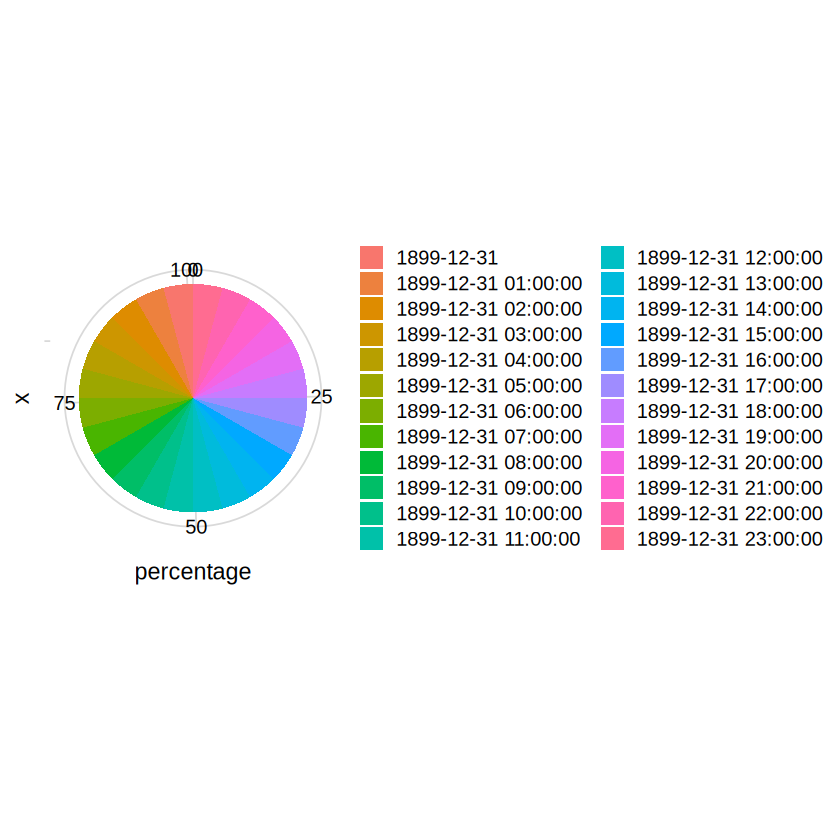

In [20]:
df <- data.frame(
    year = unique(raw_data$Time),
    percentage = c(t(as.data.frame(cat_col_info_df$value_ratios[[1]])[1, ]))
)

bp<- ggplot(df, aes(x="", y=percentage, fill=year))+
geom_bar(width = 1, stat = "identity")
pie <- bp + coord_polar("y", start=0) + theme_minimal_grid() + theme(legend.title = element_blank())
pie